<a href="https://colab.research.google.com/github/Emerson-Costa/classificador-linear-MNIST/blob/main/TM2vc_emersonJsC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Importando as Bibliotecas necessárias para o desenvolvimento do projeto

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

* Realizando as transformações e carregando as imagens do MNIST</br>
* Dimensão das imagens 28X28<br>
* Normalização dos pixels para a faixa [0, 1] usando **média 0.1307** e **desvio padrão 0.3081**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Carregando o conjunto de dados para treino
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train = True,
    download = True,
    transform = transform
)

# Carregando os dados para teste
test_dataset = torchvision.datasets.MNIST(
    root = './data',
    train = False,
    download = True,
    transform = transform
)

# Quantidade de exemplos a serem processados de uma vez
batch_size = 64

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size= batch_size,
    shuffle=False
)

print("Número de Amostras de Treino: ", len(train_dataset))
print("Número de Amostras dos Testes: ",len(test_dataset))


100%|██████████| 9.91M/9.91M [00:00<00:00, 129MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 41.2MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 115MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]


Número de Amostras de Treino:  60000
Número de Amostras dos Testes:  10000


* Criando o Modelo de Classificação Linear

In [ ]:
class classificadorLinear(nn.Module):
  def __init__(self, input_size, num_classes):
    super(classificadorLinear, self).__init__()
    # F(W, x) = Wx + b
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    # A saída é o cálculo do Score dada por Wx + b
    out = self.linear(x)
    return out

input_size = 28 * 28
num_classes = 10
model = classificadorLinear(input_size, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("Modelo criado: ", device)

Modelo criado:  cpu


* Utilizando a função de Loss Cross-Entropy e o Otmizador Gradiente Descendente

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate_padrao = 0.01
lambda_reg_padrao = 0.001
num_epochs_padrao = 10

optimizer = optim.SGD(
    model.parameters(),
    lr = learning_rate_padrao,
    weight_decay = lambda_reg_padrao
)

print("Função de Loss: ", criterion, "\n")
print("Otimizador:\n", optimizer)

Função de Loss:  CrossEntropyLoss() 

Otimizador:
 SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0.001
)


* Implementação do laço de Treinamento do Modelo

In [ ]:
loss_history = []
print("Iniciando o treinamento aguade...")

for epoch in range(num_epochs_padrao):
  model.train()
  running_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    # Score
    outputs = model(images)

    # Loss
    loss = criterion(outputs, labels)

    # Backpropagation e Gradiente
    optimizer.zero_grad()
    loss.backward()

    # Otmização
    optimizer.step()

    running_loss += loss.item()

  epoch_loss = running_loss / len(train_loader)
  loss_history.append(epoch_loss)
  print(f"Epoch [{epoch+1}/{num_epochs_padrao}], Loss: {epoch_loss:.4f}")

print("Treinamento concluído!")

Iniciando o treinamento aguade...
Epoch [1/10], Loss: 0.4693
Epoch [2/10], Loss: 0.3335
Epoch [3/10], Loss: 0.3123
Epoch [4/10], Loss: 0.3015
Epoch [5/10], Loss: 0.2942
Epoch [6/10], Loss: 0.2889
Epoch [7/10], Loss: 0.2850
Epoch [8/10], Loss: 0.2819
Epoch [9/10], Loss: 0.2793
Epoch [10/10], Loss: 0.2771
Treinamento concluído!


* Gráfico do Loss

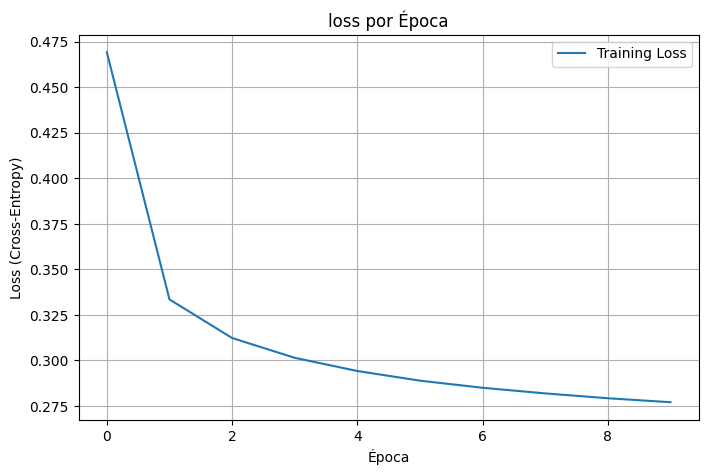

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Training Loss')
plt.title("loss por Época")
plt.xlabel('Época')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend()
plt.grid(True)
plt.show()

* Acurácia e Matriz de Confusão


Acurácia no conjunto de teste: 92.18%




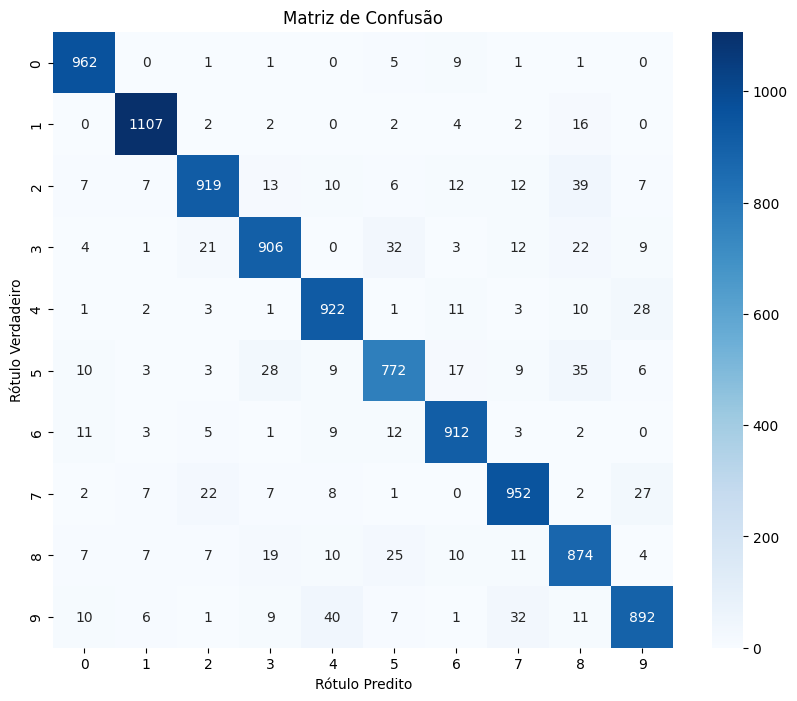

In [ ]:
model.eval()
y_true = []
y_pred = []
correct = 0
total = 0

with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"\nAcurácia no conjunto de teste: {accuracy:.2f}%\n\n")

# Gráfico da Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)
class_names = [str(i) for i in range(10)]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Matriz de Confusão")
plt.ylabel("Rótulo Verdadeiro")
plt.xlabel('Rótulo Predito')
plt.show()